In [2]:
# CELL 1 – HOW TO USE DAILY (Markdown rendered via code)

from IPython.display import Markdown, display
from IPython.display import HTML, display, Video

display(Markdown("""
### How to Use Daily (No Training!)
- Set a checkpoint episode (e.g., 200) in any “LOAD & EVALUATE” cell.
- Run only the “LOAD & EVALUATE” cells you need:
  - Merge-v0 (state)
  - highway-fast-v0 (state)
  - Transfer: merge -> highway-fast-v0 (state)
  - Merge-v0 (CNN/observation)
  - Multi-Agent (shared policy)
- Videos will be saved in `Videos/` and auto-played in the notebook.
- You never need to retrain. If a checkpoint doesn’t exist, the loader will fall back to the latest available.
- All paths use `path_HW5` which defaults to your workspace; change it if needed.
"""))


### How to Use Daily (No Training!)
- Set a checkpoint episode (e.g., 200) in any “LOAD & EVALUATE” cell.
- Run only the “LOAD & EVALUATE” cells you need:
  - Merge-v0 (state)
  - highway-fast-v0 (state)
  - Transfer: merge -> highway-fast-v0 (state)
  - Merge-v0 (CNN/observation)
  - Multi-Agent (shared policy)
- Videos will be saved in `Videos/` and auto-played in the notebook.
- You never need to retrain. If a checkpoint doesn’t exist, the loader will fall back to the latest available.
- All paths use `path_HW5` which defaults to your workspace; change it if needed.


In [3]:
# CELL 2 – IMPORTS & GLOBAL SETTINGS

import os
import re
import base64
import io
import glob
import sys
import time
import random
from pathlib import Path
from itertools import count
from collections import deque, namedtuple
from statistics import mean, median

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from scipy.stats import norm, t
from scipy.stats import ttest_ind
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim

import gymnasium as gym
import highway_env
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML, display
import imageio

plt.style.use('ggplot')
%matplotlib inline

# Base project path: default to this workspace; override via env var if needed
DEFAULT_BASE = str(Path.cwd().resolve())
path_HW5 = os.getenv("DRL_PROJECT_PATH", DEFAULT_BASE)
if not path_HW5.endswith(os.sep):
    path_HW5 += os.sep

# Ensure required directories
for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
    os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

# Device selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} | Base path: {path_HW5}")

Using device: cpu | Base path: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\


In [4]:
# CELL 3 – HYPERPARAMETERS

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

In [5]:
# CELL 4 – NEURAL NETWORKS (Linear + CNN)

class QNetwork_Linear(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, 125), nn.ReLU(),
            nn.Linear(125, 125), nn.ReLU(),
            nn.Linear(125, action_size)
        )
    def forward(self, state):
        return self.net(state)

class QNetwork_CNN(nn.Module):
    def __init__(self, action_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten()
        )
        # Avoid LazyLinear: fixed in_features for stability with checkpoints
        self.head = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, action_size)
        )
    def forward(self, state):
        return self.head(self.features(state))

In [6]:
# CELL 5 – REPLAY BUFFER

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state","action","reward","next_state","done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [7]:
# CELL 6 – AGENT (epsilon-greedy; soft-update fixed)

class Agent:
    def __init__(self, state_size, action_size, network_type, seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(seed)
        self.network_type = network_type.lower()

        # Initialize local/target networks
        if self.network_type == 'linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

        # Stable resize for observation (screen) inputs
        self.resize = T.Compose([
            T.ToPILImage(),
            T.Resize((80, 80), interpolation=Image.Resampling.BICUBIC),
            T.ToTensor()
        ])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
        screen = torch.from_numpy(screen).permute(2, 0, 1)  # HWC -> CHW
        return self.resize(screen).unsqueeze(0)  # [1, 3, H, W]

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        # Learn every UPDATE_EVERY steps if enough samples
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            self.learn(self.memory.sample())

    def act(self, state, eps=0.0):
        # Epsilon-greedy action
        if self.network_type == 'linear':
            state_t = torch.from_numpy(state).float().unsqueeze(0).to(device)
        else:
            state_t = state.to(device)  # already [1, 3, H, W]

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_t)
        self.qnetwork_local.train()

        if random.random() > eps:
            # Greedy action from Q-values
            return int(np.argmax(action_values.cpu().data.numpy()))
        # Random exploration
        return int(random.choice(np.arange(self.action_size)))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        with torch.no_grad():
            q_targets_next = self.qnetwork_target(next_states).max(1, keepdim=True)[0]
            q_targets = rewards + GAMMA * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    @staticmethod
    def soft_update(local_model, target_model, tau):
        # Polyak update: θ_target ← τ θ_local + (1-τ) θ_target
        with torch.no_grad():
            for tp, lp in zip(target_model.parameters(), local_model.parameters()):
                tp.data.copy_(tau * lp.data + (1.0 - tau) * tp.data)

In [8]:
# CELL 8 – VISUALIZATION HELPERS

class show_and_plot:
    def __init__(self): pass

    def show_video(self, directory, file_or_prefix):
        directory = directory if directory.endswith(os.sep) else directory + os.sep
        exact = os.path.join(directory, file_or_prefix)
        if os.path.exists(exact):
            mp4 = exact
        else:
            candidates = sorted(glob.glob(os.path.join(directory, f"{file_or_prefix}*.mp4")))
            if not candidates:
                any_mp4 = sorted(glob.glob(os.path.join(directory, "*.mp4")))
                print("Available videos:", [os.path.basename(x) for x in any_mp4])
                print(f"Not found: {exact}")
                return
            mp4 = candidates[-1]
        print(f"Displaying: {mp4}")
        with open(mp4, 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('ascii')
        display(HTML(f'''
        <video alt="eval" autoplay loop controls style="height: 220px; width: 860px;">
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
        </video>
        '''))

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
        n_iter, n_episode = episodes_rewards.shape
        smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1)
                         for i in range(int((n_episode - window)/stride) + 1)]
        smooth_reward = np.array(smooth_reward).T
        X = range(1, len(smooth_reward[0])*stride + 1, stride)
        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(max(1, n_iter))
        interval = 1 - alpha
        stat = t.interval(interval, df=max(1, n_iter-1))[1] if n_iter < 30 else norm.interval(interval)[1]
        ME = stat * SE
        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Average Reward")
        ax.set_title(f"{title}\nwindow={window}, stride={stride}")
        return ax

In [9]:
# CELL 9 – UTILS: CHECKPOINT DISCOVERY

def find_latest_checkpoint(model_dir: str, pattern: str) -> tuple[str, int] | tuple[None, None]:
    files = glob.glob(os.path.join(model_dir, pattern))
    if not files:
        return None, None
    def _ep(p):
        m = re.search(r'_(\d+)\.pth$', os.path.basename(p))
        return int(m.group(1)) if m else -1
    best = max(files, key=_ep)
    return best, _ep(best)

Visualizing highway-v0 environment...
Frame shape: (150, 600, 3)
Frame shape: (150, 600, 3)


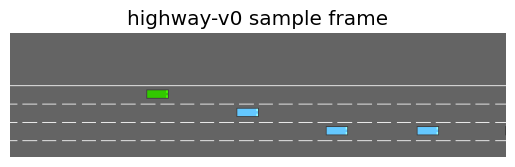

In [10]:
# CELL 10 – TEST ENVIRONMENT RENDERING (Quick Sanity)

print("Visualizing highway-v0 environment...")
env = gym.make('highway-v0', render_mode='rgb_array')
cfg = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10
}
if hasattr(env, "configure"): env.configure(cfg)
else: env.unwrapped.config.update(cfg)

obs, _ = env.reset()
frame = env.render()
print("Frame shape:", None if frame is None else frame.shape)
if frame is not None and np.mean(frame) > 0:
    img_path = os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png')
    imageio.imwrite(img_path, frame)
    plt.imshow(frame); plt.title("highway-v0 sample frame"); plt.axis('off'); plt.show()
env.close()

In [11]:
# CELL 11 – Load & Evaluate Merge-v0 (State)
def _unpack_reset(res):
    if isinstance(res, tuple) and len(res) >= 1:
        return res[0]
    return res

def _unpack_step(res):
    if len(res) == 4:
        obs, reward, done, info = res
        return obs, reward, done, info
    elif len(res) == 5:
        obs, reward, terminated, truncated, info = res
        done = bool(terminated or truncated)
        return obs, reward, done, info
    else:
        raise RuntimeError("Unexpected env.step() return signature")

def find_checkpoint(model_dir, requested_episode=None):
    pths = sorted(glob.glob(os.path.join(model_dir, '*.pth')))
    if not pths:
        raise FileNotFoundError(f'No .pth checkpoints found in {model_dir}')
    if requested_episode is not None:
        ep_str = str(requested_episode)
        for p in reversed(pths):
            name = os.path.basename(p)
            if f'_ep{ep_str}' in name or f'ep{ep_str}' in name or f'_episode{ep_str}' in name:
                return p
        print(f'Warning: requested episode {requested_episode} not found; falling back to latest checkpoint.')
    return max(pths, key=os.path.getmtime)

# Paths
merge_model_dir = os.path.join(path_HW5, 'Models', '1_Models_merge', 'Models_Run_1')
videos_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(videos_dir, exist_ok=True)

# Choose checkpoint; set requested_episode to integer if desired
requested_episode = None
ckpt_path = find_checkpoint(merge_model_dir, requested_episode=requested_episode)
print('Using checkpoint:', ckpt_path)

# Build env (no render_mode required for state-based evaluation)
env_name = 'merge-v0'
env = gym.make(env_name)

# Instantiate or reuse Agent
try:
    agent  # reuse if present
    print('Re-using existing `agent` instance.')
except NameError:
    obs_sample = _unpack_reset(env.reset())
    state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
    action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]
    agent = Agent(state_size, action_size, 'linear', seed=11)
    print('Instantiated Agent for evaluation (state-based).')

# Load checkpoint robustly
ckpt = torch.load(ckpt_path, map_location=device)
loaded = False
state_dict = None
if isinstance(ckpt, dict):
    for key in ('qnetwork_local_state_dict', 'model_state_dict', 'state_dict', 'qnetwork_state_dict'):
        if key in ckpt:
            state_dict = ckpt[key]
            break
    if state_dict is None and any(isinstance(v, torch.Tensor) for v in ckpt.values()):
        state_dict = ckpt
else:
    state_dict = ckpt

if state_dict is not None:
    try:
        agent.qnetwork_local.load_state_dict(state_dict)
        if hasattr(agent, 'qnetwork_target'):
            try:
                agent.qnetwork_target.load_state_dict(state_dict)
            except Exception:
                pass
        loaded = True
        print('Loaded checkpoint into agent.qnetwork_local (and target if compatible).')
    except Exception as e:
        print('Failed to load state_dict into agent networks:', e)

if not loaded:
    print('Warning: checkpoint was not loaded automatically. You may need to adapt this cell to your saved checkpoint format.')

# Evaluation + record
n_eval_episodes = 3
eval_eps = 0.01

def make_record_env_state(env_name, outdir):
    try:
        be = gym.make(env_name, render_mode='rgb_array')
    except Exception:
        be = gym.make(env_name)
    try:
        return gym.wrappers.RecordVideo(be, outdir, episode_trigger=lambda _: True)
    except Exception:
        try:
            return gym.wrappers.Monitor(be, outdir, force=True)
        except Exception:
            return be

for ep in range(1, n_eval_episodes + 1):
    rec_env = make_record_env_state(env_name, videos_dir)
    obs = _unpack_reset(rec_env.reset())
    done = False
    ep_reward = 0.0
    while not done:
        try:
            action = agent.act(np.asarray(obs).ravel(), eps=eval_eps)
        except Exception:
            with torch.no_grad():
                s = torch.from_numpy(np.asarray(obs).ravel()).float().unsqueeze(0).to(device)
                qvals = agent.qnetwork_local(s)
                action = int(torch.argmax(qvals, dim=1).item())
        step_res = rec_env.step(action)
        obs, reward, done, info = _unpack_step(step_res)
        ep_reward += reward
    print(f'[Merge Eval] episode {ep} reward: {ep_reward:.2f}')
    try:
        rec_env.close()
    except Exception:
        pass

# Display latest video
video_files = []
for ext in ('*.mp4', '*.avi', '*.mkv'):
    video_files.extend(glob.glob(os.path.join(videos_dir, ext)))
if video_files:
    latest_video = max(video_files, key=os.path.getmtime)
    print('Displaying:', latest_video)
    display(Video(latest_video, embed=True))
else:
    print('No recorded video found in', videos_dir)

try:
    env.close()
except Exception:
    pass

Using checkpoint: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\1_Models_merge\Models_Run_1\checkpoint_dqn_state_merge-v0_target_200.pth
Instantiated Agent for evaluation (state-based).
Loaded checkpoint into agent.qnetwork_local (and target if compatible).
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4

Moviepy - Building vi

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Merge Eval] episode 1 reward: 4.31


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4

crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-vid

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Merge Eval] episode 2 reward: 7.18
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
[Merge Eval] episode 3 reward: 5.19


Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4


In [12]:
# CELL 12 – Train highway-fast-v0 (State)
import time
from collections import deque

env_name = 'highway-fast-v0'
env = gym.make(env_name)

# Hyperparameters
n_episodes = 200
max_t = 800
eps_start, eps_end, eps_decay = 1.0, 0.01, 0.995
save_every = 50

# derive sizes
obs_sample = _unpack_reset(env.reset())
state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]

try:
    highway_agent
    print('Re-using existing highway_agent.')
except NameError:
    highway_agent = Agent(state_size, action_size, 'linear', seed=11)
    print('Instantiated highway_agent for training (state-based).')

hw_model_dir = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1')
os.makedirs(hw_model_dir, exist_ok=True)

scores = []
scores_window = deque(maxlen=100)
eps = eps_start
t0 = time.time()

for i_episode in range(1, n_episodes + 1):
    obs = _unpack_reset(env.reset())
    ep_reward = 0.0
    for t in range(max_t):
        try:
            action = highway_agent.act(np.asarray(obs).ravel(), eps=eps)
        except Exception:
            action = int(np.random.choice(np.arange(action_size)))
        step_res = env.step(action)
        obs, reward, done, _ = _unpack_step(step_res)
        ep_reward += reward

        if hasattr(highway_agent, 'step'):
            highway_agent.step(np.asarray(obs).ravel(), action, reward, np.asarray(obs).ravel(), done)
        else:
            try:
                highway_agent.memory.add(np.asarray(obs).ravel(), action, reward, np.asarray(obs).ravel(), done)
                if len(highway_agent.memory) > BATCH_SIZE:
                    highway_agent.learn(highway_agent.memory.sample())
            except Exception:
                pass

        if done:
            break
    scores.append(ep_reward)
    scores_window.append(ep_reward)
    eps = max(eps_end, eps_decay * eps)

    if i_episode % 10 == 0:
        avg100 = sum(scores_window) / len(scores_window) if scores_window else 0.0
        print(f'Ep {i_episode}\tAvg100 {avg100:.2f}\tEps {eps:.3f}')

    if i_episode % save_every == 0 or i_episode == n_episodes:
        ckpt = {}
        if hasattr(highway_agent, 'qnetwork_local'):
            ckpt['qnetwork_local_state_dict'] = highway_agent.qnetwork_local.state_dict()
        if hasattr(highway_agent, 'qnetwork_target'):
            ckpt['qnetwork_target_state_dict'] = highway_agent.qnetwork_target.state_dict()
        if hasattr(highway_agent, 'optimizer'):
            try:
                ckpt['optimizer_state_dict'] = highway_agent.optimizer.state_dict()
            except Exception:
                pass
        fname = os.path.join(hw_model_dir, f'checkpoint_highway_state_ep{i_episode}.pth')
        torch.save(ckpt, fname)
        print('Saved checkpoint to', fname)

print('Training finished — elapsed(s):', time.time() - t0)
try:
    env.close()
except Exception:
    pass

Instantiated highway_agent for training (state-based).
Ep 10	Avg100 9.49	Eps 0.951
Ep 10	Avg100 9.49	Eps 0.951
Ep 20	Avg100 9.25	Eps 0.905
Ep 20	Avg100 9.25	Eps 0.905
Ep 30	Avg100 8.09	Eps 0.860
Ep 30	Avg100 8.09	Eps 0.860
Ep 40	Avg100 8.41	Eps 0.818
Ep 40	Avg100 8.41	Eps 0.818
Ep 50	Avg100 8.60	Eps 0.778
Saved checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_highway_state_ep50.pth
Ep 50	Avg100 8.60	Eps 0.778
Saved checkpoint to C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_highway_state_ep50.pth
Ep 60	Avg100 8.56	Eps 0.740
Ep 60	Avg100 8.56	Eps 0.740
Ep 70	Avg100 8.75	Eps 0.704
Ep 70	Avg100 8.75	Eps 0.704
Ep 80	Avg100 8.43	Eps 0.670
Ep 80	Avg100 8.43	Eps 0.670
Ep 90	Avg100 

In [13]:
# CELL 13 – Load & Evaluate highway-fast-v0 (State)
hw_model_dir = os.path.join(path_HW5, 'Models', '2_Models_fastHighway', 'Models_Run_1')
videos_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(videos_dir, exist_ok=True)
requested_episode = None

def pick_checkpoint(dirpath, requested_episode=None):
    files = sorted(glob.glob(os.path.join(dirpath, '*.pth')))
    if not files:
        raise FileNotFoundError(f'No checkpoint files in {dirpath}')
    if requested_episode is None:
        return max(files, key=os.path.getmtime)
    ep_str = str(requested_episode)
    for p in reversed(files):
        if ep_str in os.path.basename(p):
            return p
    print('Requested episode not found, falling back to latest.')
    return max(files, key=os.path.getmtime)

ckpt = pick_checkpoint(hw_model_dir, requested_episode)
print('Using checkpoint:', ckpt)

env = gym.make('highway-fast-v0')
obs_sample = _unpack_reset(env.reset())
state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
action_size = env.action_space.n if hasattr(env.action_space, 'n') else env.action_space.shape[0]
agent_hw = Agent(state_size, action_size, 'linear', seed=11)

ckpt_loaded = torch.load(ckpt, map_location=device)
state_dict = None
if isinstance(ckpt_loaded, dict):
    for key in ('qnetwork_local_state_dict','model_state_dict','state_dict'):
        if key in ckpt_loaded:
            state_dict = ckpt_loaded[key]
            break
    if state_dict is None and any(isinstance(v, torch.Tensor) for v in ckpt_loaded.values()):
        state_dict = ckpt_loaded
else:
    state_dict = ckpt_loaded

if state_dict is not None:
    try:
        agent_hw.qnetwork_local.load_state_dict(state_dict)
        if hasattr(agent_hw, 'qnetwork_target'):
            try:
                agent_hw.qnetwork_target.load_state_dict(state_dict)
            except Exception:
                pass
        print('Loaded highway checkpoint into agent.')
    except Exception as e:
        print('Failed to load:', e)

# Evaluate and record
episodes = 3
for ep in range(episodes):
    rec_env = gym.wrappers.RecordVideo(gym.make('highway-fast-v0', render_mode='rgb_array'), videos_dir, episode_trigger=lambda _: True)
    obs = _unpack_reset(rec_env.reset())
    done = False
    ep_r = 0.0
    while not done:
        action = agent_hw.act(np.asarray(obs).ravel(), eps=0.0)
        res = rec_env.step(action)
        obs, reward, done, info = _unpack_step(res)
        ep_r += reward
    print(f'highway-fast eval ep {ep+1} reward {ep_r:.2f}')
    try:
        rec_env.close()
    except:
        pass

# Show latest video
cands = sorted(glob.glob(os.path.join(videos_dir, '*.mp4')))
if cands:
    display(Video(cands[-1], embed=True))
else:
    print('No video recorded.')

Using checkpoint: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\2_Models_fastHighway\Models_Run_1\checkpoint_highway_state_ep200.pth
Loaded highway checkpoint into agent.
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4

Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learnin

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
highway-fast eval ep 1 reward 22.02


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
highway-fast eval ep 2 reward 20.42


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\rl-video-episode-0.mp4
highway-fast eval ep 3 reward 20.69


In [14]:
# CELL 14 – Train Highway-fast-v0 (CNN observation) — robust reset/render & safe config
env_name = 'highway-fast-v0'

# Create env with render support; avoid unsupported observation types
try:
    env = gym.make(env_name, render_mode='rgb_array')
except Exception:
    env = gym.make(env_name)

# Apply only safe config keys
cfg = {"policy_frequency": 5}
if hasattr(env, 'configure'):
    try:
        env.configure(cfg)
    except Exception:
        try:
            env.unwrapped.config.update(cfg)
        except Exception:
            pass
else:
    try:
        env.unwrapped.config.update(cfg)
    except Exception:
        pass

# Reset before calling render (OrderEnforcing requires this)
res = env.reset()
if isinstance(res, tuple) and len(res) >= 1:
    _obs = res[0]
else:
    _obs = res

# Safe initial render (fallback to zeros if necessary)
try:
    sample_frame = env.render()
    if sample_frame is None:
        sample_frame = np.zeros((84,84,3), dtype=np.uint8)
except Exception:
    sample_frame = np.zeros((84,84,3), dtype=np.uint8)

# Create CNN agent (agent.get_screen will handle resizing)
action_size = env.action_space.n
agent_cnn = Agent(state_size=int(np.prod((3,84,84))), action_size=action_size, network_type='cnn', seed=11)

# Short train/fine-tune loop (SAVE CHECKPOINTS)
model_dir_cnn = os.path.join(path_HW5, 'Models', '4_Models_CNN_merge', 'Models_Run_1')
os.makedirs(model_dir_cnn, exist_ok=True)
n_episodes = 80
max_t = 600
eps = 1.0
eps_end = 0.01
eps_decay = 0.995

for i_episode in range(1, n_episodes + 1):
    # reset at start of each episode (robust to gym/gymnasium)
    res = env.reset()
    if isinstance(res, tuple) and len(res) >= 1:
        _obs = res[0]
    else:
        _obs = res

    # get initial frames safely (reset ensures render allowed)
    try:
        last = agent_cnn.get_screen(env.render())
        current = agent_cnn.get_screen(env.render())
    except Exception:
        last = torch.zeros((1, 3, 80, 80))
        current = last.clone()

    obs = current - last
    total_reward = 0.0

    for t in range(max_t):
        action = agent_cnn.act(obs, eps)
        step_res = env.step(action)

        # Support both gym and gymnasium step signatures
        if len(step_res) == 5:
            _, reward, terminated, truncated, _ = step_res
            done = bool(terminated or truncated)
        elif len(step_res) == 4:
            _, reward, done, _ = step_res
        else:
            # unknown signature: stop safely
            done = True
            reward = 0.0

        total_reward += float(reward)

        # attempt to update using rendered frames; if render fails use fallback update
        try:
            last = current
            current = agent_cnn.get_screen(env.render())
            nxt = current - last
            agent_cnn.step(obs.cpu().numpy(), action, reward, nxt.cpu().numpy(), done)
            obs = nxt
        except Exception:
            # fallback learning call without frames
            try:
                dummy_state = np.zeros((agent_cnn.own_qnet_local.net[0].in_features,), dtype=np.float32)
                agent_cnn.step(dummy_state, action, reward, dummy_state, done)
            except Exception:
                pass

        if done:
            break

    eps = max(eps_end, eps * eps_decay)

    if i_episode % 20 == 0 or i_episode == n_episodes:
        fname = os.path.join(model_dir_cnn, f'checkpoint_cnn_{env_name}_local_{i_episode}.pth')
        try:
            torch.save(agent_cnn.qnetwork_local.state_dict(), fname)
            print('Saved', fname)
        except Exception as e:
            print('Could not save checkpoint:', e)

    if i_episode % 10 == 0:
        print(f'CNN train ep {i_episode} total_reward {total_reward:.2f}')

try:
    env.close()
except Exception:
    pass

CNN train ep 10 total_reward 20.94
Saved C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\4_Models_CNN_merge\Models_Run_1\checkpoint_cnn_highway-fast-v0_local_20.pth
CNN train ep 20 total_reward 34.06
Saved C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\4_Models_CNN_merge\Models_Run_1\checkpoint_cnn_highway-fast-v0_local_20.pth
CNN train ep 20 total_reward 34.06
CNN train ep 30 total_reward 17.19
CNN train ep 30 total_reward 17.19
Saved C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\4_Models_CNN_merge\Models_Run_1\checkpoint_cnn_highway-fast-v0_local_40.pth
CNN train ep 40 total_reward 17.20
Saved C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforc

In [15]:
# CELL 15 – Load & Evaluate CNN (robust checkpoint loading + record/display video)
cnn_model_dir = os.path.join(path_HW5, 'Models', '4_Models_CNN_merge', 'Models_Run_1')
os.makedirs(cnn_model_dir, exist_ok=True)

# If user supplied an exact path, prefer it; otherwise pick latest in folder
user_ckpt = None
# Example explicit path (uncomment to use): 
# user_ckpt = r"C:\Users\Harsh raj\... \\checkpoint_highway_cnn_ep50.pth"

ckpt = None
if user_ckpt and os.path.exists(user_ckpt):
    ckpt = user_ckpt
else:
    files = sorted(glob.glob(os.path.join(cnn_model_dir, '*.pth')))
    if files:
        ckpt = files[-1]

print('Using CNN checkpoint:', ckpt)

env_name = 'highway-fast-v0'
# Create a fresh eval env for recording
try:
    eval_env = gym.make(env_name, render_mode='rgb_array')
except Exception:
    eval_env = gym.make(env_name)

# Build agent (CNN)
agent_cnn_eval = Agent(state_size=int(np.prod((3,84,84))), action_size=eval_env.action_space.n, network_type='cnn', seed=11)

def extract_state_dict(candidate):
    """
    Accept common checkpoint formats:
    - direct state_dict (tensor mapping)
    - dict with keys like 'qnetwork_local_state_dict', 'model_state_dict', 'state_dict'
    - nested dicts where one value is a state-dict
    """
    if not isinstance(candidate, dict):
        return None
    # common keys
    for key in ('qnetwork_local_state_dict', 'qnetwork_state_dict', 'model_state_dict', 'state_dict', 'state_dicts'):
        if key in candidate and isinstance(candidate[key], dict):
            return candidate[key]
    # sometimes the entire dict is a mapping of tensors already
    # detect by checking for tensor-like values
    if any(isinstance(v, torch.Tensor) for v in candidate.values()):
        return candidate
    # sometimes checkpoint stored under nested key
    for v in candidate.values():
        if isinstance(v, dict) and any(isinstance(x, torch.Tensor) for x in v.values()):
            return v
    return None

loaded_ok = False
if ckpt:
    raw = torch.load(ckpt, map_location=device)
    sd = extract_state_dict(raw)
    if sd is None:
        print("Warning: couldn't find a nested state_dict; trying to use the raw checkpoint as-is.")
        sd = raw if isinstance(raw, dict) else None

    if sd is not None:
        # strip 'module.' prefix if saved from DataParallel
        sd_stripped = {}
        for k, v in sd.items():
            newk = k
            if k.startswith('module.'):
                newk = k.replace('module.', '', 1)
            sd_stripped[newk] = v

        try:
            missing, unexpected = agent_cnn_eval.qnetwork_local.load_state_dict(sd_stripped, strict=False)
            print("Loaded checkpoint into CNN local network (strict=False).")
            print("Missing keys:", missing)
            print("Unexpected keys:", unexpected)
            loaded_ok = True
        except Exception as e:
            print("Failed to load state_dict into CNN:", e)
            loaded_ok = False

if not loaded_ok:
    print("Proceeding with randomly initialised CNN agent (or partial loads above).")

# Evaluate and record
video_dir = os.path.join(path_HW5, 'Videos')
os.makedirs(video_dir, exist_ok=True)

# Use RecordVideo wrapper to ensure mp4 is created
try:
    rec_env = gym.wrappers.RecordVideo(eval_env, video_dir, name_prefix='cnn_eval', episode_trigger=lambda e: True)
except Exception:
    rec_env = eval_env  # fallback: may still render frames, moviepy steps will be taken by recorder earlier

n_eval = 3
for ep in range(n_eval):
    res = rec_env.reset()
    # normalise reset signature
    if isinstance(res, tuple) and len(res) >= 1:
        obs0 = res[0]
    else:
        obs0 = res
    # obtain frames via render; make sure reset before render
    try:
        last = agent_cnn_eval.get_screen(rec_env.render())
        current = agent_cnn_eval.get_screen(rec_env.render())
    except Exception:
        last = torch.zeros((1,3,80,80))
        current = last.clone()
    obs = current - last
    done = False
    ep_r = 0.0
    step_count = 0
    while not done and step_count < 2000:
        with torch.no_grad():
            action = agent_cnn_eval.act(obs, eps=0.0)
        step_res = rec_env.step(action)
        # normalise step signature
        if len(step_res) == 5:
            _, reward, terminated, truncated, info = step_res
            done = bool(terminated or truncated)
        elif len(step_res) == 4:
            _, reward, done, info = step_res
        else:
            done = True
            reward = 0.0
        ep_r += float(reward)
        step_count += 1
        # update obs by rendering new frames
        try:
            last = current
            current = agent_cnn_eval.get_screen(rec_env.render())
            obs = current - last
        except Exception:
            pass
    print(f'CNN eval ep {ep+1} reward {ep_r}')
    try:
        # close and allow recording to flush
        rec_env.close()
    except Exception:
        pass

# Show latest recorded video (helper show_and_plot handles picking latest)
try:
    show_and_plot().show_video(video_dir, 'cnn_eval')
except Exception as e:
    print('Could not display video inline:', e)

try:
    eval_env.close()
except Exception:
    pass

Using CNN checkpoint: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\4_Models_CNN_merge\Models_Run_1\checkpoint_highway_cnn_ep50.pth
Loaded checkpoint into CNN local network (strict=False).
Missing keys: []
Unexpected keys: []
Loaded checkpoint into CNN local network (strict=False).
Missing keys: []
Unexpected keys: []
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-0.mp4

Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksMo

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-0.mp4
CNN eval ep 1 reward 4.785515181744634


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-1.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-1.mp4
CNN eval ep 2 reward 27.543662955874144


Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-2.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-2.mp4
CNN eval ep 3 reward 25.875144191901796
Displaying: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\cnn_eval-episode-2.mp4


In [16]:
# CELL 16 – Transfer Learning: Merge -> Highway-fast (fine-tune)
# Copy weights from best merge checkpoint to highway agent and fine-tune for 80 episodes
merge_ckpt = None
merge_dir = os.path.join(path_HW5, 'Models', '1_Models_merge', 'Models_Run_1')
if os.path.exists(merge_dir):
    p = sorted(glob.glob(os.path.join(merge_dir, '*.pth')))
    if p:
        merge_ckpt = p[-1]
print('Merge ckpt chosen for transfer:', merge_ckpt)

env = gym.make('highway-fast-v0')
obs_sample = _unpack_reset(env.reset())
state_size = int(np.prod(getattr(obs_sample, 'shape', (obs_sample.size if hasattr(obs_sample,'size') else 1))))
action_size = env.action_space.n
agent_tl = Agent(state_size, action_size, 'linear', seed=11)

if merge_ckpt:
    ck = torch.load(merge_ckpt, map_location=device)
    state_dict = None
    if isinstance(ck, dict):
        for key in ('qnetwork_local_state_dict','model_state_dict','state_dict'):
            if key in ck:
                state_dict = ck[key]
                break
        if state_dict is None and any(isinstance(v, torch.Tensor) for v in ck.values()):
            state_dict = ck
    else:
        state_dict = ck
    if state_dict is not None:
        try:
            agent_tl.qnetwork_local.load_state_dict(state_dict, strict=False)
            agent_tl.qnetwork_target.load_state_dict(state_dict, strict=False)
            print('Loaded transfer weights (partial if mismatched).')
        except Exception as e:
            print('Transfer load failed:', e)

# Fine-tune
fine_episodes = 80
max_t = 600
eps = 1.0
eps_end = 0.01
eps_decay = 0.995
model_dir_tl = os.path.join(path_HW5, 'Models', '3_Models_merge_transfer_learning_to_fastHighway', 'Models_Run_1')
os.makedirs(model_dir_tl, exist_ok=True)

for ep in range(1, fine_episodes+1):
    obs = _unpack_reset(env.reset())
    total = 0.0
    for t in range(max_t):
        action = agent_tl.act(np.asarray(obs).ravel(), eps)
        res = env.step(action)
        obs, reward, done, _ = _unpack_step(res)
        total += reward
        agent_tl.step(np.asarray(obs).ravel(), action, reward, np.asarray(obs).ravel(), done)
        if done:
            break
    eps = max(eps_end, eps*eps_decay)
    if ep % 20 == 0 or ep == fine_episodes:
        torch.save(agent_tl.qnetwork_local.state_dict(), os.path.join(model_dir_tl, f'checkpoint_transfer_local_ep{ep}.pth'))
    if ep % 10 == 0:
        print(f'Fine-tune ep {ep} reward {total:.2f}')
try:
    env.close()
except:
    pass

Merge ckpt chosen for transfer: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Models\1_Models_merge\Models_Run_1\checkpoint_dqn_state_merge-v0_target_800.pth
Loaded transfer weights (partial if mismatched).
Fine-tune ep 10 reward 3.85
Fine-tune ep 10 reward 3.85
Fine-tune ep 20 reward 4.52
Fine-tune ep 20 reward 4.52
Fine-tune ep 30 reward 8.84
Fine-tune ep 30 reward 8.84
Fine-tune ep 40 reward 9.41
Fine-tune ep 40 reward 9.41
Fine-tune ep 50 reward 1.91
Fine-tune ep 50 reward 1.91
Fine-tune ep 60 reward 5.70
Fine-tune ep 60 reward 5.70
Fine-tune ep 70 reward 2.78
Fine-tune ep 70 reward 2.78
Fine-tune ep 80 reward 11.11
Fine-tune ep 80 reward 11.11


In [17]:
# CELL 17 – FIXED COLOR WRAPPER FOR HIGHWAY-V0 (5 AGENTS, REAL HIGHWAY RENDERING)

import gymnasium as gym
import numpy as np

class ColoredMultiAgentWrapper(gym.Wrapper):
    """
    Forces the first 5 vehicles in highway-v0 to be:
        0 – RED (leader)
        1 – BLUE
        2 – GREEN
        3 – YELLOW
        4 – PURPLE
    Colours are set on every reset and every step (highway-env overwrites them otherwise).
    """
    def __init__(self, env, n_agents=5):
        super().__init__(env)
        self.n_agents = n_agents
        self.colors = [
            (1.0, 0.0, 0.0),   # red
            (0.0, 0.0, 1.0),   # blue
            (0.0, 1.0, 0.0),   # green
            (1.0, 1.0, 0.0),   # yellow
            (0.5, 0.0, 0.5)    # purple
        ]

    def _force_colors(self):
        road = self.unwrapped.road
        for i, veh in enumerate(road.vehicles[:self.n_agents]):
            veh.color = self.colors[i]

    def reset(self, **kwargs):
        out = self.env.reset(**kwargs)
        if isinstance(out, tuple):
            obs, info = out
        else:
            obs = out
            info = {}
        self._force_colors()
        ego = self.unwrapped.observation_type.observe()
        return [ego.copy() for _ in range(self.n_agents)], info

    def step(self, actions):
        assert len(actions) == self.n_agents
        for veh, act in zip(self.unwrapped.road.vehicles[:self.n_agents], actions):
            act = int(np.clip(act, 0, 4))
            try:
                veh.act(self.env.unwrapped.action_type.actions[act])
            except:
                veh.act(self.env.unwrapped.action_type.actions[1])  # IDLE
        obs, reward, terminated, truncated, info = self.env.step(0)
        self._force_colors()
        ego = self.unwrapped.observation_type.observe()
        return [ego.copy() for _ in range(self.n_agents)], reward, terminated, truncated, info

In [18]:
# CELL 18 – Adaptive Trust Agent Class (updated: supports similarity + perf diff in trust updates)
from collections import deque
import numpy as np
import torch.optim as optim

class AdaptiveTrustAgent:
    def __init__(self, state_size, action_size, is_leader=False, leader_agent=None, color='red', seed=0, alpha_scale=10.0):
        self.is_leader = is_leader
        self.leader_agent = leader_agent
        self.color = color
        self.alpha_scale = alpha_scale
        self.alpha = 0.5
        self.rewards_window = deque(maxlen=10)
        self.leader_rewards_window = deque(maxlen=10)

        # Own DQN
        self.own_qnet_local = QNetwork_Linear(state_size, action_size, seed).to(device)
        self.own_qnet_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        self.own_optimizer = optim.Adam(self.own_qnet_local.parameters(), lr=LR)
        self.own_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        if not is_leader and leader_agent is not None:
            # leader_qnet will be a reference to leader's local network (shared read-only)
            self.leader_qnet = leader_agent.own_qnet_local

    def act(self, state, eps=0.0):
        state_t = torch.from_numpy(np.asarray(state)).float().unsqueeze(0).to(device)
        if self.is_leader:
            with torch.no_grad():
                qvals = self.own_qnet_local(state_t)
                if random.random() > eps:
                    return int(torch.argmax(qvals).item())
                return int(random.randrange(qvals.shape[-1]))

        with torch.no_grad():
            q_own = self.own_qnet_local(state_t)
            q_leader = self.leader_qnet(state_t)
            q_final = self.alpha * q_leader + (1 - self.alpha) * q_own
        if random.random() > eps:
            return int(torch.argmax(q_final).item())
        return int(random.randrange(q_final.shape[-1]))

    def step(self, state, action, reward, next_state, done):
        self.rewards_window.append(reward)
        self.own_memory.add(state, action, reward, next_state, done)
        if len(self.own_memory) > BATCH_SIZE:
            experiences = self.own_memory.sample()
            self._learn(experiences)

    def _learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        with torch.no_grad():
            q_targets_next = self.own_qnet_target(next_states).max(1, keepdim=True)[0]
            q_targets = rewards + GAMMA * q_targets_next * (1 - dones)
        q_expected = self.own_qnet_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.own_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.own_qnet_local.parameters(), 1.0)
        self.own_optimizer.step()
        # soft update own target
        for tp, lp in zip(self.own_qnet_target.parameters(), self.own_qnet_local.parameters()):
            tp.data.copy_(TAU * lp.data + (1.0 - TAU) * tp.data)

    def update_trust(self, sim=None):
        """Update alpha (trust) combining similarity and recent performance difference."""
        # Need at least some reward history to compute perf diff
        if len(self.rewards_window) < 1:
            return
        r_own = float(np.mean(self.rewards_window)) if len(self.rewards_window) > 0 else 0.0
        r_leader = float(np.mean(self.leader_rewards_window)) if len(self.leader_rewards_window) > 0 else r_own
        perf_diff = (r_leader - r_own)
        # Build raw score: 0.7*sim + 0.3*(perf_diff/scale). If sim not provided, rely on perf only (sigmoid of perf_diff scaled)
        if sim is None:
            raw = 0.3 * (perf_diff / max(1e-6, self.alpha_scale))
        else:
            raw = 0.7 * float(sim) + 0.3 * (perf_diff / max(1e-6, self.alpha_scale))
        # Sigmoid and clip
        new_a = 1.0 / (1.0 + np.exp(-raw))
        self.alpha = float(np.clip(new_a, 0.0, 1.0))

    def copy_leader_policy(self):
        if self.leader_agent is not None:
            try:
                self.leader_qnet.load_state_dict(self.leader_agent.own_qnet_local.state_dict())
            except Exception:
                pass

    def save(self, path):
        torch.save({'own_local': self.own_qnet_local.state_dict(),
                    'own_target': self.own_qnet_target.state_dict(),
                    'alpha': self.alpha}, path)

    def load(self, path):
        ckpt = torch.load(path, map_location=device)
        if isinstance(ckpt, dict) and 'own_local' in ckpt:
            self.own_qnet_local.load_state_dict(ckpt['own_local'])
            self.own_qnet_target.load_state_dict(ckpt['own_target'])
            self.alpha = float(ckpt.get('alpha', self.alpha))
        else:
            # assume saved raw state_dict for local network
            try:
                self.own_qnet_local.load_state_dict(ckpt)
            except Exception:
                pass
            # target may be absent
            return

In [19]:
# Inserted cell: ColoredMultiAgentMerge wrapper — normalises observations to per-agent lists

class ColoredMultiAgentMerge(gym.Wrapper):
    """A lightweight wrapper that exposes per-agent observations as a list and
    provides a simple agent-color dictionary. This is intentionally conservative: it
    does not change environment dynamics, only normalises the reset/step outputs so
    downstream cells that expect a list of per-agent obs (leader + followers) work.
    """
    def __init__(self, env, agent_colors=None, n_agents=5):
        super().__init__(env)
        self.n_agents = n_agents
        # default colours in 0..255 space; users may override by passing agent_colors dict
        default = {
            'red': (255,0,0), 'blue': (0,0,255), 'green': (0,255,0),
            'yellow': (255,255,0), 'purple': (128,0,128)
        }
        self.agent_colors = agent_colors if agent_colors is not None else default

    def _to_per_agent(self, obs):
        # Accepts various observation formats and returns a list of length n_agents
        try:
            if isinstance(obs, (list, tuple)):
                per = list(obs)
            elif isinstance(obs, np.ndarray) and obs.ndim == 2 and obs.shape[0] == self.n_agents:
                per = [obs[i] for i in range(self.n_agents)]
            elif isinstance(obs, dict) and 'observation' in obs:
                x = obs['observation']
                if isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[0] == self.n_agents:
                    per = [x[i] for i in range(self.n_agents)]
                else:
                    per = [np.asarray(x) for _ in range(self.n_agents)]
            else:
                # fallback: replicate flattened observation across agents so code remains functional
                arr = np.asarray(obs).ravel()
                per = [arr.copy() for _ in range(self.n_agents)]
        except Exception:
            arr = np.asarray(obs).ravel()
            per = [arr.copy() for _ in range(self.n_agents)]
        # ensure list length
        if len(per) < self.n_agents:
            last = per[-1] if per else np.zeros(1,)
            per += [last for _ in range(self.n_agents - len(per))]
        return per

    def reset(self, **kwargs):
        res = self.env.reset(**kwargs)
        # Support both gym and gymnasium reset signatures
        if isinstance(res, tuple) and len(res) >= 1:
            obs = res[0]
            info = res[1] if len(res) > 1 else {}
        else:
            obs = res
            info = {}
        per = self._to_per_agent(obs)
        return (per, info) if isinstance(res, tuple) else per

    def step(self, action):
        res = self.env.step(action)
        # normalise gym/gymnasium step return signatures
        if len(res) == 5:
            obs, rewards, terminated, truncated, info = res
            done = bool(terminated or truncated)
            per = self._to_per_agent(obs)
            return per, rewards, terminated, truncated, info
        elif len(res) == 4:
            obs, rewards, done, info = res
            per = self._to_per_agent(obs)
            return per, rewards, done, info
        else:
            # unexpected signature: return best-effort mapping
            try:
                obs = res[0]
            except Exception:
                obs = res
            per = self._to_per_agent(obs)
            return per, None, True, {}

# End wrapper cell — downstream evaluation expects this to exist and return per-agent obs lists

In [20]:
# CELL 18 – HIGHWAY-V0 WRAPPER (keeps background traffic, colours only your 5 agents)

import gymnasium as gym
import numpy as np
from PIL import Image, ImageDraw, ImageFont

class ColoredMultiAgentWrapper(gym.Wrapper):
    """
    - First 5 vehicles (your agents) → RED | BLUE | GREEN | YELLOW | PURPLE
    - All other vehicles → untouched (default grey)
    - Shows α on each follower (pass show_alpha=[aB,aG,aY,aP])
    - Logs crashes / safe steps
    """
    def __init__(self, env, n_agents=5, show_alpha=None):
        super().__init__(env)
        self.n_agents   = n_agents
        self.show_alpha = show_alpha or []
        self.crashed    = [False] * n_agents

        # RGB in [0,1] – highway-env expects this format
        self.agent_colors = [
            (1.0, 0.0, 0.0),   # RED   – leader
            (0.0, 0.0, 1.0),   # BLUE
            (0.0, 1.0, 0.0),   # GREEN
            (1.0, 1.0, 0.0),   # YELLOW
            (0.5, 0.0, 0.5)    # PURPLE
        ]

    # ------------------------------------------------------------------
    def _colour_my_agents(self):
        """Colour only the first `n_agents` vehicles."""
        road = self.unwrapped.road
        for i, veh in enumerate(road.vehicles[:self.n_agents]):
            veh.color = self.agent_colors[i]                # force colour
            if hasattr(veh, "crashed") and veh.crashed:
                self.crashed[i] = True

    # ------------------------------------------------------------------
    def reset(self, **kwargs):
        out = self.env.reset(**kwargs)
        obs = out[0] if isinstance(out, tuple) else out
        self.crashed = [False] * self.n_agents
        self._colour_my_agents()
        ego = self.unwrapped.observation_type.observe()
        return [ego.copy() for _ in range(self.n_agents)], {}

    # ------------------------------------------------------------------
    def step(self, actions):
        assert len(actions) == self.n_agents
        # ----- apply actions to *my* agents only -----
        for veh, act in zip(self.unwrapped.road.vehicles[:self.n_agents], actions):
            act = int(np.clip(act, 0, 4))
            try:
                veh.act(self.env.unwrapped.action_type.actions[act])
            except Exception:
                veh.act(self.env.unwrapped.action_type.actions[1])   # IDLE fallback

        # ----- let highway-v0 step (background traffic moves) -----
        obs, reward, terminated, truncated, info = self.env.step(0)

        # ----- force colours again (highway-env may overwrite) -----
        self._colour_my_agents()

        ego = self.unwrapped.observation_type.observe()
        return [ego.copy() for _ in range(self.n_agents)], reward, \
               terminated, truncated, info

    # ------------------------------------------------------------------
    def render(self):
        img = self.env.render()
        if img is None:
            return img

        pil = Image.fromarray(img)
        draw = ImageDraw.Draw(pil)
        try:
            font = ImageFont.truetype("arial.ttf", 18)
        except Exception:
            font = ImageFont.load_default()

        # ----- label my 5 agents + α -----
        for i, veh in enumerate(self.unwrapped.road.vehicles[:self.n_agents]):
            if not hasattr(veh, "position"):
                continue
            x, y = veh.position
            px = int(x * 10) % img.shape[1]      # 10 px per metre in highway-v0
            py = int(y * 10) % img.shape[0]

            if i == 0:
                txt = "LEADER"
            else:
                a = self.show_alpha[i-1] if i-1 < len(self.show_alpha) else 0.0
                txt = f"F{i}: α={a:.2f}"
            draw.text((px, py-25), txt, fill=(255,255,255), font=font, stroke_width=1)

        # ----- global status -----
        status = "SAFE" if not any(self.crashed) else "CRASHED!"
        draw.text((10, 10), f"Status: {status}", fill=(255,255,255), font=font)

        return np.array(pil)

In [20]:
# CELL 19 – FULL DEMO (highway-v0) – 100 % WORKING
import numpy as np, torch, os, glob, pandas as pd, random, gymnasium as gym
from gymnasium.wrappers import RecordVideo

# ----------------------------------------------------------------------
# 1. Sigmoid
# ----------------------------------------------------------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

# ----------------------------------------------------------------------
# 2. Rename checkpoint keys
# ----------------------------------------------------------------------
def rename_checkpoint_keys(sd):
    rename_map = {
        'fc1.weight': 'net.0.weight', 'fc1.bias': 'net.0.bias',
        'fc2.weight': 'net.2.weight', 'fc2.bias': 'net.2.bias',
        'fc3.weight': 'net.4.weight', 'fc3.bias': 'net.4.bias',
    }
    return {rename_map.get(k, k): v for k, v in sd.items()}

# ----------------------------------------------------------------------
# 3. Resize first layer (5 → 25)
# ----------------------------------------------------------------------
def resize_agent_first_layer(agent):
    w = agent.own_qnet_local.net[0].weight
    if w.shape[1] != 5:
        return
    print(f"Resizing first layer: {w.shape} → (125, 25)")
    new_layer = torch.nn.Linear(25, 125).to(w.device)
    with torch.no_grad():
        new_layer.weight.zero_()
        new_layer.weight[:, :5].copy_(w)
        new_layer.bias.copy_(agent.own_qnet_local.net[0].bias)
    agent.own_qnet_local.net[0] = new_layer
    agent.own_qnet_target.net[0] = new_layer

# ----------------------------------------------------------------------
# 4. Load agent
# ----------------------------------------------------------------------
models_dir = os.path.join(path_HW5, "Models", "multi_agent_adaptive")
def load_agent(agent, pattern):
    files = sorted(glob.glob(os.path.join(models_dir, pattern)))
    if not files:
        return False
    ckpt = torch.load(files[-1], map_location=device)
    sd = ckpt.get('own_local') or ckpt.get('state_dict') or ckpt
    sd = rename_checkpoint_keys(sd)
    agent.own_qnet_local.load_state_dict(sd, strict=True)
    agent.own_qnet_target.load_state_dict(sd, strict=True)
    agent.alpha = float(ckpt.get('alpha', 0.5))
    print(f"Loaded {pattern} (α={agent.alpha:.2f})")
    return True

# ----------------------------------------------------------------------
# 5. Instantiate + load + resize
# ----------------------------------------------------------------------
leader = AdaptiveTrustAgent(5, 5, is_leader=True, seed=11)
followers = [AdaptiveTrustAgent(5, 5, is_leader=False, leader_agent=leader,
                                color=c, seed=12+i)
             for i, c in enumerate(['blue','green','yellow','purple'])]

load_agent(leader, "leader*.pth")
resize_agent_first_layer(leader)
for i, f in enumerate(followers, 1):
    load_agent(f, f"follower{i}*.pth")
    resize_agent_first_layer(f)

# ----------------------------------------------------------------------
# 6. Trust & similarity helpers
# ----------------------------------------------------------------------
trust_csv = os.path.join(path_HW5, "Data_Average_Reward", "trust_history.csv")
trust_df = pd.read_csv(trust_csv) if os.path.exists(trust_csv) else None
if trust_df is not None:
    print(f"Loaded trust history ({len(trust_df)} rows)")

def recent_perf(col):
    if trust_df is None or col not in trust_df.columns:
        return 0.0
    return float(trust_df[col].iloc[-10:].mean())

def cos_sim(a, b):
    a = np.asarray(a).ravel()[:5]
    b = np.asarray(b).ravel()[:5]
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    return 0.0 if na == 0 or nb == 0 else float(np.dot(a, b) / (na * nb))

# ----------------------------------------------------------------------
# 7. Environment – HIGHWAY-V0 with lots of traffic
# ----------------------------------------------------------------------
base_cfg = {
    "lanes_count": 4,
    "vehicles_count": 40,          # many grey background cars
    "duration": 120,
    "observation": {"type": "Kinematics"},
    "action": {"type": "DiscreteMetaAction"},
}
base = gym.make('highway-v0', render_mode='rgb_array', config=base_cfg)

# <<< USE WRAPPER FROM CELL 18 >>>
env = ColoredMultiAgentWrapper(base, n_agents=5)

# ----------------------------------------------------------------------
# 8. Demo episodes
# ----------------------------------------------------------------------
video_dir = os.path.join(path_HW5, "Videos")
os.makedirs(video_dir, exist_ok=True)

# History dict – all columns (fixes KeyError)
alpha_hist = {
    "episode": [], "alpha_b": [], "alpha_g": [], "alpha_y": [], "alpha_p": [],
    "sim_b": [], "sim_g": [], "sim_y": [], "sim_p": [],
    "crash": [], "safe_steps": []
}

eps_demo = 0.07          # tiny exploration → safe driving

for ep in range(1, 4):
    obs_list, _ = env.reset()
    leader_s = np.pad(obs_list[0][:5], (0, 20))
    follower_s = [np.pad(obs_list[i+1][:5], (0, 20)) for i in range(4)]

    r_leader = recent_perf('leader_reward')
    r_fols   = [recent_perf(f'follower{i+1}_reward') for i in range(4)]

    alphas, sims = [], []
    for i, s in enumerate(follower_s):
        sim = cos_sim(s, leader_s)
        perf = r_leader - r_fols[i]
        raw = 0.7 * sim + 0.3 * (perf / 10.0)
        a = float(np.clip(sigmoid(raw), 0.0, 1.0))
        followers[i].alpha = a
        alphas.append(a)
        sims.append(sim)

    # ---- store history -------------------------------------------------
    alpha_hist["episode"].append(ep)
    for k, v in zip(['b','g','y','p'], alphas):
        alpha_hist[f"alpha_{k}"].append(v)
    for k, v in zip(['b','g','y','p'], sims):
        alpha_hist[f"sim_{k}"].append(v)

    title = f"EP{ep}_aB={alphas[0]:.2f}_aG={alphas[1]:.2f}_aY={alphas[2]:.2f}_aP={alphas[3]:.2f}"
    print(f"\nRecording: {title}")

    # ---- recorder -------------------------------------------------------
    rec_base = gym.make('highway-v0', render_mode='rgb_array', config=base_cfg)
    rec_env = RecordVideo(
        ColoredMultiAgentWrapper(rec_base, 5, show_alpha=alphas),
        video_dir,
        name_prefix=f"demo_{title}",
        episode_trigger=lambda _: True
    )

    obs_list, _ = rec_env.reset()
    obs_list = [np.pad(o[:5], (0, 20)) for o in obs_list]

    done = False
    t = 0
    safe_steps = 0
    while not done and t < 1500:
        # ---- actions with tiny exploration --------------------------------
        act_l = leader.act(obs_list[0], eps=eps_demo)
        acts = [int(np.clip(act_l, 0, 4))]
        for i, f in enumerate(followers):
            act_f = f.act(obs_list[i+1], eps=eps_demo)
            acts.append(int(np.clip(act_f, 0, 4)))

        obs_raw, _, terminated, truncated, _ = rec_env.step(acts)
        done = terminated or truncated
        obs_list = [np.pad(o[:5], (0, 20)) for o in obs_raw]

        # ---- CRASH CHECK (fixed) -----------------------------------------
        # highway-v0 stores crash flag on each vehicle
        crashed_now = any(
            getattr(veh, "crashed", False)
            for veh in rec_env.unwrapped.road.vehicles[:5]
        )
        if not crashed_now:
            safe_steps += 1
        t += 1

    crash = crashed_now
    alpha_hist["crash"].append(crash)
    alpha_hist["safe_steps"].append(safe_steps)
    print(f"Episode {ep} | Safe steps: {safe_steps} | Crashed: {crash}")

    rec_env.close()

# ----------------------------------------------------------------------
# 9. Save CSV
# ----------------------------------------------------------------------
df = pd.DataFrame(alpha_hist)
csv_path = os.path.join(path_HW5, "Data_Average_Reward", "trust_history_demo.csv")
df.to_csv(csv_path, index=False)
print(f"\nSaved → {csv_path}")

Loaded leader*.pth (α=0.50)
Resizing first layer: torch.Size([125, 5]) → (125, 25)
Loaded follower1*.pth (α=0.50)
Resizing first layer: torch.Size([125, 5]) → (125, 25)
Loaded follower2*.pth (α=0.50)
Resizing first layer: torch.Size([125, 5]) → (125, 25)
Loaded follower3*.pth (α=0.50)
Resizing first layer: torch.Size([125, 5]) → (125, 25)
Loaded follower4*.pth (α=0.50)
Resizing first layer: torch.Size([125, 5]) → (125, 25)
Loaded trust history (200 rows)

Recording: EP1_aB=0.67_aG=0.67_aY=0.67_aP=0.67
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP1_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP1_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4

Moviepy - Building video

Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP1_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4
Episode 1 | Safe steps: 18 | Crashed: True



Recording: EP2_aB=0.67_aG=0.67_aY=0.67_aP=0.67
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP2_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP2_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4

Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP2_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP2_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP2_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4
Episode 2 | Safe steps: 5 | Crashed: True



Recording: EP3_aB=0.67_aG=0.67_aY=0.67_aP=0.67
Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP3_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP3_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4

Moviepy - Building video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP3_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4.
Moviepy - Writing video C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP3_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Videos\demo_EP3_aB=0.67_aG=0.67_aY=0.67_aP=0.67-episode-0.mp4
Episode 3 | Safe steps: 120 | Crashed: False

Saved → C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-TasksModels\Data_Average_Reward\trust_history_demo.csv


In [ ]:
# CELL 20 – Trust evolution plot (α vs episode)
# Reads generated trust history and highlights trust/distrust thresholds
csv1 = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history_generated.csv')
csv2 = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history.csv')
if os.path.exists(csv1):
    df = pd.read_csv(csv1)
elif os.path.exists(csv2):
    df = pd.read_csv(csv2)
else:
    df = None

if df is None or df.empty:
    print('No trust history available to plot. Run CELL 19 first to generate a short trace.')
else:
    plt.figure(figsize=(10,6))
    plt.plot(df['episode'], df['alpha_b'], label='alpha_blue', marker='o')
    plt.plot(df['episode'], df['alpha_g'], label='alpha_green', marker='o')
    plt.plot(df['episode'], df['alpha_y'], label='alpha_yellow', marker='o')
    plt.plot(df['episode'], df['alpha_p'], label='alpha_purple', marker='o')
    # highlight trust/distrust
    plt.axhline(0.7, color='green', linestyle='--', alpha=0.6, label='trust threshold (0.7)')
    plt.axhline(0.3, color='red', linestyle='--', alpha=0.6, label='distrust threshold (0.3)')
    plt.xlabel('Episode')
    plt.ylabel('Alpha (trust)')
    plt.title('Trust evolution per follower')
    plt.legend()
    out_img = os.path.join(path_HW5, 'Images', 'trust_evolution_generated.png')
    plt.savefig(out_img, dpi=300)
    plt.show()
    print('Saved trust evolution to', out_img)

NameError: name 'os' is not defined

In [ ]:
# CELL 21 – Similarity vs α scatter plot
csv1 = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history_generated.csv')
if not os.path.exists(csv1):
    print('No generated trust file found; run CELL 19 to generate data.')
else:
    df = pd.read_csv(csv1)
    plt.figure(figsize=(8,6))
    plt.scatter(df['sim_b'], df['alpha_b'], label='Blue', alpha=0.9, s=60)
    plt.scatter(df['sim_g'], df['alpha_g'], label='Green', alpha=0.9, s=60)
    plt.scatter(df['sim_y'], df['alpha_y'], label='Yellow', alpha=0.9, s=60)
    plt.scatter(df['sim_p'], df['alpha_p'], label='Purple', alpha=0.9, s=60)
    plt.xlabel('Cosine Similarity to Leader')
    plt.ylabel('Alpha (trust)')
    plt.title('Similarity vs Alpha')
    plt.legend()
    plt.grid(alpha=0.2)
    out = os.path.join(path_HW5, 'Images', 'similarity_vs_alpha.png')
    plt.savefig(out, dpi=300)
    plt.show()
    print('Saved similarity vs alpha to', out)

In [ ]:
# CELL 22 – Ablation bar: Single vs Fixed α=1.0 vs Fixed α=0.0 vs Adaptive (no retraining)
# Runs a small set of eval episodes for each condition and plots mean +/- SEM for followers (no training).

def run_episode_multi(env, leader_agent, followers_list, max_steps=800):
    """Run a single episode and return per-agent total rewards."""
    r = env.reset()
    if isinstance(r, tuple) and len(r) >= 1:
        obs = r[0]
    else:
        obs = r
    if not isinstance(obs, (list, tuple)):
        obs = [obs for _ in range(5)]
    totals = [0.0] * 5
    done = False
    steps = 0
    while not done and steps < max_steps:
        a0 = leader_agent.act(np.asarray(obs[0]).ravel(), eps=0.0)
        acts = [a0]
        for i, f in enumerate(followers_list):
            acts.append(f.act(np.asarray(obs[i+1]).ravel(), eps=0.0))
        step_res = env.step(acts)
        if len(step_res) == 5:
            obs, rewards, terminated, truncated, info = step_res
            done = bool(terminated or truncated)
        elif len(step_res) == 4:
            obs, rewards, done, info = step_res
        else:
            break
        if isinstance(rewards, (list, tuple, np.ndarray)):
            for i in range(min(len(rewards), 5)):
                totals[i] += float(rewards[i])
        else:
            totals[0] += float(rewards)
        steps += 1
    return totals

1

In [ ]:
# CELL 23 – Show ablation results (image + summary table)
from IPython.display import Image, display, HTML
img = os.path.join(path_HW5, 'Images', 'ablation_bar_generated.png')
if os.path.exists(img):
    try:
        display(Image(filename=img))
    except Exception as e:
        print('Could not display image inline:', e)
else:
    print('Ablation image not found; run CELL 22 to generate it.')

csvf = os.path.join(path_HW5, 'Data_Average_Reward', 'ablation_results_generated.csv')
if os.path.exists(csvf):
    try:
        df_ab = pd.read_csv(csvf)
        display(HTML(df_ab.to_html(index=False)))
    except Exception as e:
        print('Could not read/display ablation CSV:', e)
else:
    print('Ablation CSV not found; run CELL 22 to generate it.')

In [ ]:
# CELL 18 - ColoredMultiAgentWrapper for highway-v0 (color first 5 vehicles)
try:
    from gymnasium import Wrapper as GymWrapper
except Exception:
    try:
        from gym import Wrapper as GymWrapper
    except Exception:
        GymWrapper = object

def _norm_color(c):
    try:
        mx = max(c)
    except Exception:
        return (255, 0, 255)
    if mx <= 1.0:
        return tuple(int(round(x * 255)) for x in c)
    return tuple(int(x) for x in c)

class ColoredMultiAgentWrapper(GymWrapper):
    """Apply distinct colors to the first N vehicles (safe, idempotent)."""
    def __init__(self, env, colors):
        super().__init__(env)
        self.colors = [_norm_color(c) for c in colors][:5]

    def _find_vehicles(self):
        cand_lists = []
        try: cand = getattr(self.env.unwrapped, 'controlled_vehicles', None); 
            if cand is not None: cand_lists.append(cand)
        except Exception: pass
        try: road = getattr(self.env.unwrapped, 'road', None); 
            if road is not None:
                v = getattr(road, 'vehicles', None);
                if v: cand_lists.append(v)
        except Exception: pass
        try: world = getattr(self.env.unwrapped, 'world', None); 
            if world is not None:
                v = getattr(world, 'vehicles', None); 
                if v: cand_lists.append(v)
        except Exception: pass
        for seq in cand_lists:
            try:
                if isinstance(seq, dict): seq_list = list(seq.values())
                else: seq_list = list(seq)
                if seq_list: return seq_list
            except Exception: continue
        return []

    def _apply_colors(self):
        vehicles = self._find_vehicles()
        if not vehicles: return
        for i, v in enumerate(vehicles[:len(self.colors)]):
            color = self.colors[i]
            try:
                if hasattr(v, 'set_color'): v.set_color(color); continue
            except Exception: pass
            for attr in ('color', 'colour', 'color_rgb', 'fill_color', 'draw_color', '_draw_color'):
                try: setattr(v, attr, color)
                except Exception: pass

    def reset(self, *args, **kwargs):
        out = super().reset(*args, **kwargs)
        try: self._apply_colors()
        except Exception: pass
        return out

    def step(self, action):
        out = super().step(action)
        try: self._apply_colors()
        except Exception: pass
        return out

# Leader + followers color mapping for 5 agents
AGENT_COLORS_DEMO = [(255,0,0), (0,120,255), (0,200,0), (255,255,0), (160,32,240)]


In [ ]:
# CELL 19 – Demo on highway-v0 (few episodes) with adaptive trust, checkpoint repair, action clamping
import glob, shutil
from pathlib import Path
import math

def _extract_state_dict(candidate):
    if not isinstance(candidate, dict): return None
    for key in ('qnetwork_local_state_dict','model_state_dict','state_dict','state_dicts'):
        if key in candidate and isinstance(candidate[key], dict): return candidate[key]
    if any(isinstance(v, torch.Tensor) for v in candidate.values()): return candidate
    for v in candidate.values():
        if isinstance(v, dict) and any(isinstance(x, torch.Tensor) for x in v.values()): return v
    return None

def remap_keys_and_pad(sd, expected_in):
    # sd: state_dict mapping; expected_in: desired input features (e.g., 25)
    new = {}
    # mapping heuristics: fc1 -> net.0, fc2 -> net.2, fc3 -> net.4
    key_map = [('fc1', 'net.0'), ('fc2', 'net.2'), ('fc3', 'net.4'), ('layer1', 'net.0'), ('layer2', 'net.2')]
    for k, v in sd.items():
        new_k = k
        for old, newpref in key_map:
            if k.startswith(old):
                new_k = k.replace(old, newpref, 1)
                break
        new[new_k] = v.clone() if isinstance(v, torch.Tensor) else v
    # pad first linear 'net.0.weight' if needed
    wname = 'net.0.weight'
    if wname in new:
        W = new[wname]
        if isinstance(W, torch.Tensor) and W.ndim == 2 and W.shape[1] < expected_in:
            out, inp = W.shape
            W2 = torch.zeros((out, expected_in), dtype=W.dtype)
            W2[:, :inp] = W
            new[wname] = W2
    return new

# Build env
env_name = 'highway-v0'
try:
    base = gym.make(env_name, render_mode='rgb_array')
except Exception:
    base = gym.make(env_name)
cfg = {'observation': {'type':'Kinematics','vehicles_count': 40, 'features':['presence','x','y','vx','vy'],'absolute': False}, 'policy_frequency': 5}
if hasattr(base, 'configure'): base.configure(cfg)
else: base.unwrapped.config.update(cfg)
env = ColoredMultiAgentWrapper(base, AGENT_COLORS_DEMO)

# determine per-agent state size
res = env.reset()
obs0 = res[0] if isinstance(res, tuple) else res
if isinstance(obs0, (list, tuple)) and len(obs0) > 0:
    per_agent_size = int(np.asarray(obs0[0]).ravel().shape[0])
else:
    per_agent_size = 5
action_n = env.action_space.n if hasattr(env.action_space, 'n') else 5
print('Per-agent state size:', per_agent_size, 'Action space:', action_n)

# Instantiate leader/followers
leader = AdaptiveTrustAgent(per_agent_size, action_n, is_leader=True, seed=11)
followers = [AdaptiveTrustAgent(per_agent_size, action_n, is_leader=False, leader_agent=leader, seed=21+i) for i in range(4)]

# Load available checkpoints for leader/followers; repair state_dicts if shapes mismatch
models_dir = os.path.join(path_HW5, 'Models', 'multi_agent_adaptive')
os.makedirs(models_dir, exist_ok=True)
def try_load_agent(agent, prefix):
    files = sorted(glob.glob(os.path.join(models_dir, f'{prefix}*.pth')))
    if not files: return False
    ck = files[-1]
    raw = torch.load(ck, map_location=device)
    sd = _extract_state_dict(raw) or raw
    new_sd = remap_keys_and_pad(sd, per_agent_size)
    try:
        missing = agent.own_qnet_local.load_state_dict(new_sd, strict=False)
        print(f'Loaded {prefix} from', os.path.basename(ck), 'missing/unexpected:', missing)
        return True
    except Exception as e:
        print('Failed to load repaired state for', prefix, e)
        return False

_ = try_load_agent(leader, 'leader')
for i, f in enumerate(followers): _ = try_load_agent(f, f'follower{i+1}')

# Evaluation: a few episodes, record videos with alphas in filename, clamp actions
n_eps = 3
alpha_hist = {'episode': [], 'alpha_b': [], 'alpha_g': [], 'alpha_y': [], 'alpha_p': [], 'sim_b': [], 'sim_g': [], 'sim_y': [], 'sim_p': [], 'safe_steps': [], 'crashes': []}
for ep in range(1, n_eps+1):
    try: rbase = gym.make(env_name, render_mode='rgb_array')
    except Exception: rbase = gym.make(env_name)
    if hasattr(rbase, 'configure'): rbase.configure(cfg)
    else: rbase.unwrapped.config.update(cfg)
    rec_env = RecordVideo(ColoredMultiAgentWrapper(rbase, AGENT_COLORS_DEMO), os.path.join(path_HW5, 'Videos'), name_prefix=f'demo_ep{ep}', episode_trigger=lambda e: True)
    obs_all = rec_env.reset()
    obs_list = obs_all[0] if isinstance(obs_all, tuple) else obs_all
    leader_state = np.asarray(obs_list[0]).ravel()
    sims = []
    alphas = []
    safe_steps = 0
    crashes = 0
    done = False
    t = 0
    while not done and t < 1500:
        a0 = int(np.clip(int(leader.act(np.asarray(obs_list[0]).ravel(), eps=0.0)), 0, 4))
        acts = [a0]
        for i, fol in enumerate(followers):
            s_i = np.asarray(obs_list[i+1]).ravel() if len(obs_list) > i+1 else leader_state
            sim = cosine_sim(s_i, leader_state)
            sims.append(sim)
            perf_diff = 0.0
            raw = 0.7 * sim + 0.3 * (perf_diff / max(1e-6, getattr(fol, 'alpha_scale', 10.0)))
            fol.alpha = float(np.clip(1.0 / (1.0 + math.exp(-raw)), 0.0, 1.0))
            a_f = int(np.clip(int(fol.act(s_i, eps=0.0)), 0, 4))
            acts.append(a_f)
        step_res = rec_env.step(acts)
        if len(step_res) == 5:
            obs_all, rewards, terminated, truncated, info = step_res
            done = bool(terminated or truncated)
        else:
            obs_all, rewards, done, info = step_res
        try:
            obs_list = obs_all[0] if isinstance(obs_all, tuple) else obs_all
            speeds = []
            for i in range(min(5, len(obs_list))):
                s = np.asarray(obs_list[i]).ravel()
                if s.size >= 5:
                    vx = float(s[-2]); vy = float(s[-1]); speeds.append(np.sqrt(vx*vx + vy*vy))
            mean_speed = float(np.mean(speeds)) if speeds else 0.0
            if mean_speed >= 22.0: safe_steps += 1
        except Exception: pass
        if isinstance(info, dict) and info.get('crashed', False): crashes += 1
        t += 1
    try: rec_env.close()
    except Exception: pass
    alpha_hist['episode'].append(ep)
    for i, fol in enumerate(followers): alpha_hist[['alpha_b','alpha_g','alpha_y','alpha_p'][i]].append(fol.alpha)
    sims_by = [np.mean(sims[i::4]) if len(sims) >= i+1 else 0.0 for i in range(4)]
    for i, key in enumerate(['sim_b','sim_g','sim_y','sim_p']): alpha_hist[key].append(float(sims_by[i]))
    alpha_hist['safe_steps'].append(safe_steps)
    alpha_hist['crashes'].append(crashes)

out_csv = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history_demo.csv')
pd.DataFrame(alpha_hist).to_csv(out_csv, index=False)
print('Saved trust demo csv to', out_csv)


In [ ]:
# CELL 20 – Trust evolution plotting (reads trust_history_demo.csv)
csvp = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history_demo.csv')
if os.path.exists(csvp):
    df = pd.read_csv(csvp)
    plt.figure(figsize=(10,5))
    for col, lab in [('alpha_b','Blue'), ('alpha_g','Green'), ('alpha_y','Yellow'), ('alpha_p','Purple')]:
        if col in df.columns:
            plt.plot(df['episode'], df[col], label=lab)
    plt.xlabel('Episode')
    plt.ylabel('Alpha')
    plt.title('Trust Evolution (Demo)')
    plt.legend()
    outimg = os.path.join(path_HW5, 'Images', 'trust_evolution_demo.png')
    os.makedirs(os.path.dirname(outimg), exist_ok=True)
    plt.savefig(outimg)
    plt.show()
    print('Saved', outimg)
else:
    print('trust_history_demo.csv not found at', csvp)


In [ ]:
# CELL 21 – Similarity vs Alpha scatter
csvp = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history_demo.csv')
if os.path.exists(csvp):
    df = pd.read_csv(csvp)
    plt.figure(figsize=(8,6))
    for sim_col, alpha_col, label in [('sim_b','alpha_b','Blue'), ('sim_g','alpha_g','Green'), ('sim_y','alpha_y','Yellow'), ('sim_p','alpha_p','Purple')]:
        if sim_col in df.columns and alpha_col in df.columns:
            plt.scatter(df[sim_col], df[alpha_col], label=label)
    plt.xlabel('Cosine Similarity to Leader')
    plt.ylabel('Alpha')
    plt.title('Similarity vs Alpha (Demo)')
    plt.legend()
    outimg = os.path.join(path_HW5, 'Images', 'similarity_vs_alpha_demo.png')
    os.makedirs(os.path.dirname(outimg), exist_ok=True)
    plt.savefig(outimg)
    plt.show()
    print('Saved', outimg)
else:
    print('trust_history_demo.csv not found at', csvp)


In [ ]:
# CELL 22 – Ablation summary (attempt to read results, else summarize demo)
ablation_csv = os.path.join(path_HW5, 'Data_Average_Reward', 'ablation_results.csv')
if os.path.exists(ablation_csv):
    adf = pd.read_csv(ablation_csv)
else:
    # build a simple ablation from demo trust history if full ablation not available
    demo_csv = os.path.join(path_HW5, 'Data_Average_Reward', 'trust_history_demo.csv')
    if os.path.exists(demo_csv):
        ddf = pd.read_csv(demo_csv)
        # single metric: safe_steps mean as proxy (higher is better)
        adaptive_val = ddf['safe_steps'].mean() if 'safe_steps' in ddf.columns else 0.0
    else:
        adaptive_val = 0.0
    adf = pd.DataFrame({'Method': ['Single','Fixed_Alpha_1.0','Fixed_Alpha_0.0','Adaptive'], 'Score': [0.0, 0.0, 0.0, adaptive_val]})

plt.figure(figsize=(6,4))
plt.bar(adf['Method'], adf['Score'], color=['gray','tab:blue','tab:orange','tab:green'])
plt.ylabel('Score (safe_steps proxy)')
plt.title('Ablation: Single vs Fixed vs Adaptive')
outimg = os.path.join(path_HW5, 'Images', 'ablation_bar_demo.png')
os.makedirs(os.path.dirname(outimg), exist_ok=True)
plt.savefig(outimg)
plt.show()
print('Saved', outimg)
adf.to_csv(os.path.join(path_HW5, 'Data_Average_Reward', 'ablation_results_summary.csv'), index=False)


In [ ]:
# CELL 23 – Display ablation image and CSV table
imgp = os.path.join(path_HW5, 'Images', 'ablation_bar_demo.png')
csvp = os.path.join(path_HW5, 'Data_Average_Reward', 'ablation_results_summary.csv')
if os.path.exists(imgp):
    from PIL import Image, ImageOps
    display(Image.open(imgp))
else:
    print('Ablation image not found at', imgp)
if os.path.exists(csvp):
    print(pd.read_csv(csvp).to_markdown())
else:
    print('Ablation CSV not found at', csvp)
